Factorisation de tenseurs non négatifs (NTF):



#### Init


In [36]:
from google.colab import drive
drive.mount('/content/drive')
%cd (/content/drive/MyDrive/Projet_A3S5/Donnees/new_cartes_epaisseur)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '(/content/drive/MyDrive/Projet_A3S5/Donnees/new_cartes_epaisseur)'
/content/drive/MyDrive/Projet_A3S5/Donnees/new_cartes_epaisseur


In [2]:
!pip install tensorly

     |████████████████████████████████| 198 kB 4.5 MB/s 
     |████████████████████████████████| 154 kB 36.1 MB/s 


In [3]:
import numpy as np
from glob import glob
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score
from sklearn import svm
from tqdm import tqdm
from sklearn.model_selection import train_test_split

list_train = []
list_test = []
label_train=[]
label_test=[]
train_ids_fem_pato = [1,6,7,12,13,19,25]
test_ids_fem_pato = [20,22,14]
train_ids_fem_sain = [18,65,66,67,68,69]
test_ids_fem_sain = [71,74,2]

datadir='/content/drive/MyDrive/Projet_A3S5/Donnees/cartes_epaisseur' 



for i in train_ids_fem_pato:
    image_name = '/femur_patho/Femur_%02d.png'%(i)
    label_train.append("pathologique")
    list_train.append(datadir + image_name)
    print()

for i in test_ids_fem_pato:
    image_name = '/femur_patho/Femur_%02d.png'%(i)
    label_test.append("pathologique")
    list_test.append(datadir + image_name)

for i in train_ids_fem_sain:
    image_name = '/femur/Femur_%02d.png'%(i)
    label_train.append("sain")
    list_train.append(datadir + image_name)

for i in test_ids_fem_sain:
    image_name = '/femur/Femur_%02d.png'%(i)
    label_test.append("sain")
    list_test.append(datadir + image_name)
    #print(np.shape(datadir + image_name))


#### Tensor formation old data

In [37]:
import numpy as np
import tensorly as tl
import tensorly.decomposition as tldc
import random
from numpy.linalg import inv

tl.set_backend('pytorch')

n0 = 60
size = (n0,n0)

i=0
train_tensor = tl.tensor(np.zeros(13*n0**2).reshape((*size , len(list_train))))
print(tl.shape(train_tensor))

for img in list_train:
    img_array = cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), size)
    img_tensor = tl.tensor(img_array)
    tl.index_update(train_tensor, tl.index[:,:,i], img_tensor)
    i+=1

j=0
test_tensor = tl.tensor(np.zeros(6*n0**2).reshape((*size , len(list_test))))
for img in list_test:
    img_array = cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), size)
    img_tensor = tl.tensor(img_array)
    tl.index_update(test_tensor, tl.index[:,:,j], img_tensor)
    j+=1


torch.Size([60, 60, 13])


#### Tensor formation new data

In [41]:
import numpy as np
import tensorly as tl
import tensorly.decomposition as tldc
import random
from numpy.linalg import inv
from glob import glob

tl.set_backend('pytorch')

n0 = 60
size = (n0,n0)

def process_img(path, size):
    return cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), size)

def load_Femur(name='recalage_affine_femur_bis', size=(60, 60)):
    images_sain, ids_sain = zip(*[[process_img(path, size), path[-6:-4]]  for path in glob(f'Femur/{name}/femur*.png')])
    images_patho, ids_patho = zip(*[[process_img(path, size), path[-6:-4]] for path in glob(f'Femur_patho/{name}/femur*.png')])

    ids = np.array(ids_sain + ids_patho)
    images = np.array(images_sain + images_patho)
    labels = np.array([0]*len(images_sain) + [1]*len(images_patho))

    return images, labels, ids

(images, labels, ids) = load_Femur()

i=0
train_tensor = tl.tensor(np.zeros(13*n0**2).reshape((*size , len(list_train))))
print(np.shape(images))

for img in list_train:
    img_array = cv2.resize(images[i,:,:], size)
    img_tensor = tl.tensor(img_array)
    tl.index_update(train_tensor, tl.index[:,:,i], img_tensor)
    i+=1

test_tensor = tl.tensor(np.zeros(6*n0**2).reshape((*size , len(list_test))))
for img in list_test:
    img_array = cv2.resize(images[i,:,:], size)
    img_tensor = tl.tensor(img_array)
    tl.index_update(test_tensor, tl.index[:,:,i], img_tensor)
    i+=1



(32, 60, 60)


IndexError: ignored

#### Parafac2 decomposition


In [19]:
### PARAFAC2
from tensorly.decomposition import parafac2

def decomp(r,n0):

  decomposition, errs = parafac2(train_tensor, r, return_errors=True, tol=1e-8, n_iter_max=500)
  est_tensor = tl.parafac2_tensor.parafac2_to_tensor(decomposition)
  est_weights, (est_A, est_B, est_C) = tl.parafac2_tensor.apply_parafac2_projections(decomposition)

  # Reformation de B (car seul Dieux sait pourquoi est_B est une liste)
  est_B = np.array([np.array(b) for b in est_B]) 

  # Calcul des solutions C pour chaque image
  C_sol = []

  for img_id in range(np.shape(list_test)[0]) :
    M = np.zeros((r,r))
    x = np.array(train_tensor[:,:,img_id].flatten())
    f = lambda n,m : est_A[n//n0,m] * est_B[n//n0, n%n0, m]
    M = np.array(np.fromfunction(f, (n0*n0,r), dtype=int))

    C_sol.append(inv(M.T@M)@M.T@x)
    
  return(C_sol,np.array(est_C))

#### Visualize decomposition

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


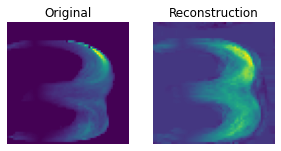

In [16]:
def decomp_visu(r,n0):

  decomposition, errs = parafac2(train_tensor, r, return_errors=True, tol=1e-8, n_iter_max=500)
  est_tensor = tl.parafac2_tensor.parafac2_to_tensor(decomposition)
  est_weights, (est_A, est_B, est_C) = tl.parafac2_tensor.apply_parafac2_projections(decomposition)

  # Reformation de B (car seul Dieux sait pourquoi est_B est une liste)
  est_B = np.array([np.array(b) for b in est_B]) 

  # Calcul des solutions C pour chaque image
  C_sol = []

  for img_id in range(np.shape(list_test)[0]) :
    M = np.zeros((r,r))
    x = np.array(test_tensor[:,:,img_id].flatten())
    f = lambda n,m : est_A[n//n0,m] * est_B[n//n0, n%n0, m]
    M = np.array(np.fromfunction(f, (n0*n0,r), dtype=int))

    C_sol.append(inv(M.T@M)@M.T@x)

  g = lambda k,i,j : est_A[i,k] * est_B[i,j,k]
  feature_images = np.array(np.fromfunction(g, (r,n0,n0), dtype=int))
    
  plt.figure(figsize=(10,20))
  plt.subplot(141)
  plt.imshow(test_tensor[:,:,1])
  plt.title("Original")
  plt.axis('off')
  plt.subplot(142)
  plt.imshow((feature_images.T@C_sol[1]).T)
  plt.title("Reconstruction")
  plt.axis('off')

r = 13
decomp_visu(r,n0)

#### SVM

In [ ]:
svc=svm.SVC(probability=True)
r = 13
(C_sol,est_C) = decomp(r,n0)

svc.fit(est_C,label_train)

y_pred=svc.predict(C_sol)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(label_test))
print(f"The model is {accuracy_score(y_pred,label_test)*100}% accurate")

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


(6, 13)


SVC(probability=True)

#### SVM Test

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


10
The model is 33.33333333333333% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


11
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


12
The model is 66.66666666666666% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


13
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


14
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


15
The model is 66.66666666666666% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


16
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


17
The model is 66.66666666666666% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


18
The model is 33.33333333333333% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


19
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


20
The model is 66.66666666666666% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


21
The model is 66.66666666666666% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


22
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


23
The model is 50.0% accurate


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


24
The model is 33.33333333333333% accurate


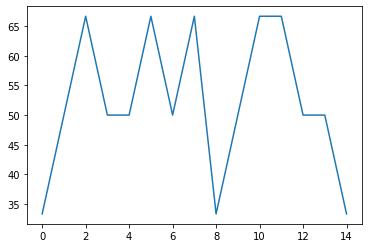

In [21]:
acc_list=[]
for i in range(10,25):
  (C_sol,est_C) = decomp(i,n0)
  svc=svm.SVC(probability=True)
  svc.fit(est_C,label_train)
  y_pred=svc.predict(C_sol)
  print(i)
  print(f"The model is {accuracy_score(y_pred,label_test)*100}% accurate")
  acc_list.append(accuracy_score(y_pred,label_test)*100)

plt.plot(acc_list)

#### SVM test 2

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


10
The model is 50.0% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique'
 'pathologique' 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


11
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique' 'sain'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


12
The model is 33.33333333333333% accurate
The prediction is ['pathologique' 'pathologique' 'sain' 'pathologique' 'pathologique'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


13
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique' 'sain'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


14
The model is 50.0% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique'
 'pathologique' 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


15
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'sain' 'pathologique'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


16
The model is 50.0% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique'
 'pathologique' 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


17
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique' 'sain'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


18
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique' 'sain'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


19
The model is 50.0% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique'
 'pathologique' 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


20
The model is 33.33333333333333% accurate
The prediction is ['pathologique' 'sain' 'pathologique' 'pathologique' 'pathologique'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


21
The model is 50.0% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique'
 'pathologique' 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


22
The model is 50.0% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique'
 'pathologique' 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


23
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique' 'sain'
 'pathologique'].


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


24
The model is 66.66666666666666% accurate
The prediction is ['pathologique' 'pathologique' 'pathologique' 'pathologique' 'sain'
 'pathologique'].


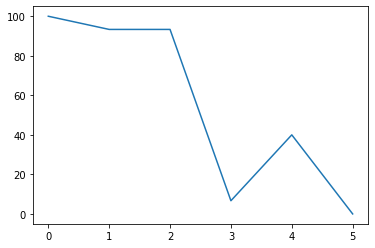

In [28]:
acc_list_count = [0,0,0,0,0,0]
for i in range(10,25):
  (C_sol,est_C) = decomp(i,n0)
  svc=svm.SVC(probability=True)
  svc.fit(est_C,label_train)
  y_pred=svc.predict(C_sol)
  print(i)
  print(f"The model is {accuracy_score(y_pred,label_test)*100}% accurate")
  print(f"The prediction is {y_pred}.")
  for j in range(6):
    if y_pred[j] == label_test[j] :
      acc_list_count[j] += 1

for i in range (6):
  acc_list_count[i] = acc_list_count[i]*100/15
plt.plot(acc_list_count)